In [5]:
#|default_exp init

# Initialization

In [6]:
!pip install torcheval

In [7]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [8]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [9]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [10]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

Note: in each layer, we reduce the grid size by 4x (because these are stride 2 convs) and we increase the nb of channels by 2x, so in the end we reduce the number of activations by 2x, so we're forcing the network to compress the information (in an intelligent way). Also, we generally want to have similar amount of computation done for each layer, that why we don't compress by 4x but rather by 2x each time.

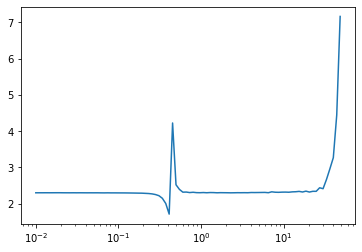

In [11]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.216,2.144,0,train
0.124,2.322,0,eval


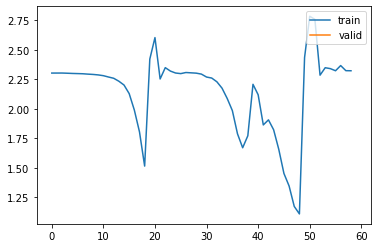

In [13]:
learn.fit(1)

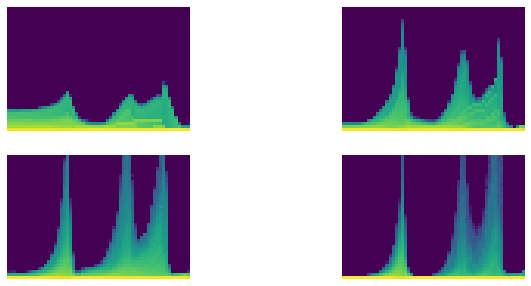

In [14]:
astats.color_dim()

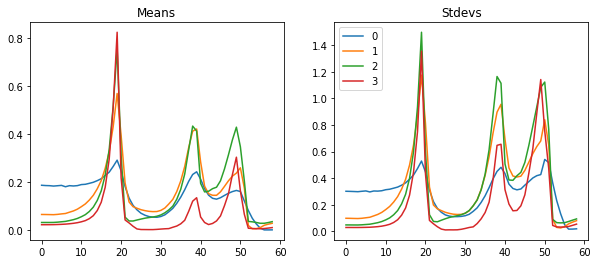

In [15]:
astats.plot_stats()

In [16]:
1+1

2

We call recall the output of specific cells using _n :

But this can be a problem when the ouput is a big cuda tensor. The following function will clear the jupyter history:

In [20]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

Similarly, if an exception is raised and a big cuda tensor is contained within this exception or a cuda out of memory error, it will stay allocated in memory. The following function will clear that:

In [21]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [22]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

In [23]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [24]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [25]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

### Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g.:

In [26]:
t = torch.tensor([1.,2.,4.,18])

In [27]:
m = t.mean(); m

tensor(6.25)

In [28]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [29]:
(t-m).pow(2).mean()

tensor(47.19)

In [30]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [31]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [32]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

Let's see that in code. So now we need two vectors.

In [33]:
t

tensor([ 1.,  2.,  4., 18.])

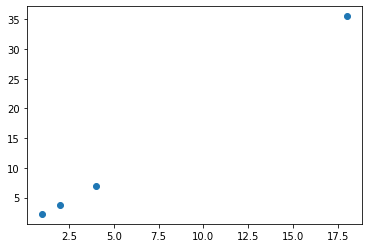

In [34]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [35]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.67,  35.81,  11.57, 275.08])

In [36]:
prod.mean()

tensor(93.53)

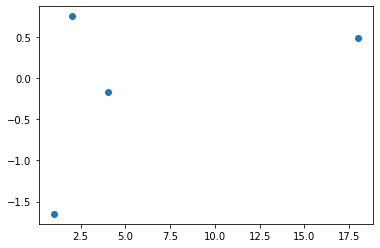

In [37]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [38]:
((t-t.mean())*(v-v.mean())).mean()

tensor(2.91)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [39]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(2.91)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [40]:
cov / (t.std() * v.std())

tensor(0.34)

It's just a scaled version of the same thing.

In [41]:
x.std()

tensor(1.13)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [42]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.19), tensor(0.96))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [43]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(-0.021637050323188304, 101.61874702453613)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [44]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(-0.003184134499988704, 0.9690546516017775)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

### Background

In [45]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [46]:
from math import sqrt

In [47]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [48]:
def lin(x, w, b): return x @ w + b

In [49]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(0.01), tensor(0.98))

In [50]:
def relu(x): return x.clamp_min(0.)

In [51]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.40), tensor(0.58))

In [52]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [53]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.40, 0.00, 0.00, 0.28, 0.00],
        [0.37, 0.00, 0.00, 0.30, 0.00],
        [0.28, 0.00, 0.00, 0.20, 0.00],
        [0.36, 0.00, 0.00, 0.30, 0.00],
        [0.25, 0.00, 0.00, 0.19, 0.00]])

### Applying an init function

All nn.module models have an apply method, and the apply is used recursively accross all the levels of depth of the model:

In [57]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [58]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight) # does this in place

In [59]:
model.apply(init_weights);

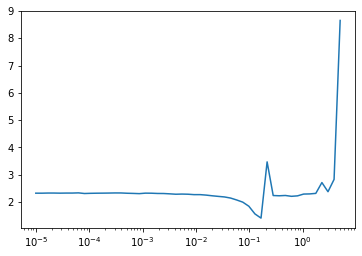

In [60]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [61]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.585,1.234,0,train
0.779,0.600,0,eval
0.819,0.488,1,train
0.834,0.459,1,eval
0.845,0.422,2,train
0.841,0.426,2,eval


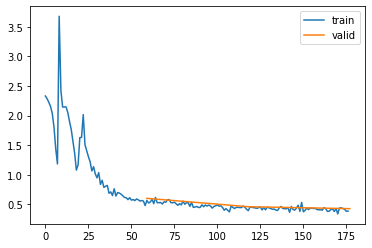

In [62]:
learn.fit(3)

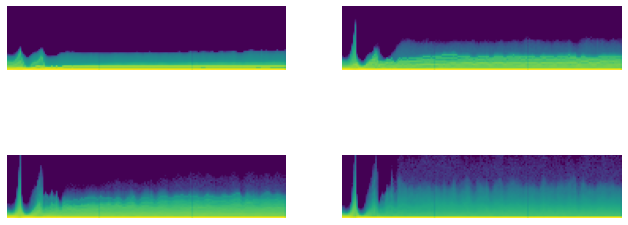

In [63]:
astats.color_dim()

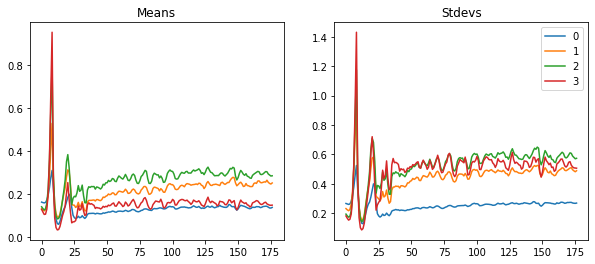

In [64]:
astats.plot_stats()

## Input normalization

It is still not working: we still don't start with a mean of zero and the sdt of 1. That's because we have normalized the weights of the models, but we haven't normalized the input, in particular for a mini batch:

In [65]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In the following experiment (which we already did further above), the input has a mean of zero and an sdt of 1:

In [66]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.24, 0.38, 0.17, 0.52],
        [0.00, 0.17, 0.23, 0.06, 0.28],
        [0.00, 0.19, 0.30, 0.11, 0.32],
        [0.00, 0.10, 0.15, 0.05, 0.21],
        [0.00, 0.31, 0.50, 0.04, 0.50]])

In [67]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [68]:
def _norm(b): return (b[0]-xmean)/xstd,b[1] # a batch is a tuple of (X,y) so that's what we need to return
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.540,1.421,0,train
0.762,0.628,0,eval
0.811,0.512,1,train
0.818,0.491,1,eval
0.842,0.427,2,train
0.843,0.426,2,eval


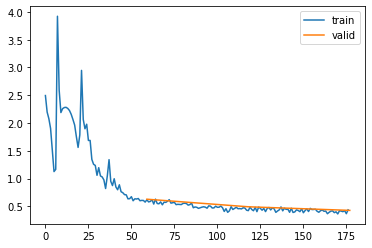

In [69]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

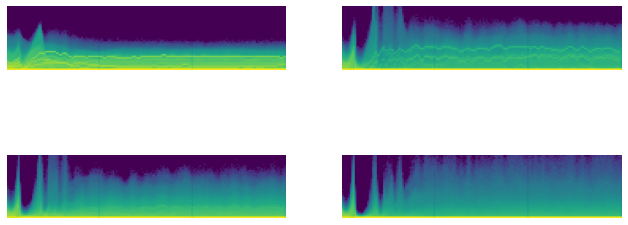

In [70]:
astats.color_dim()

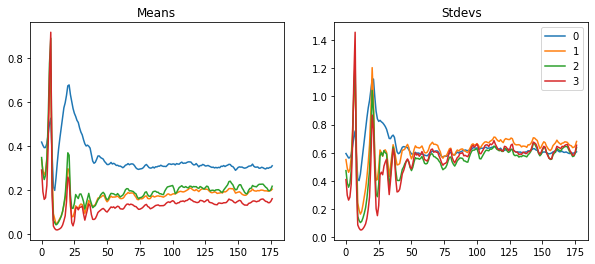

In [71]:
astats.plot_stats()

Still not perfect but a lot better, and we get an accuracy of .84

Instead of using a callback which will apply the normalization of the input for each mini-batch, we could do it with dsd.with_transform. Both methods are equally good.

In [72]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
myiter = iter(dls.train)

In [73]:
for _ in range(5):
    xb,yb = next(myiter)
    print(xb.mean(),xb.std())

tensor(0.01) tensor(1.00)
tensor(0.01) tensor(1.00)
tensor(0.01) tensor(1.00)
tensor(-0.00) tensor(0.99)
tensor(-0.00) tensor(0.99)


## General ReLU

We still don't have a mean of 0 and an sdt of 1 even at the start, cause we are measuring these stats after the Relu.

In [74]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

maxv would prevent activations from being too high.

In [75]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

With this combination of leakiness (10%) and substraction (0.4) Jeremy found that we can have a mean of 0 after this Relu.

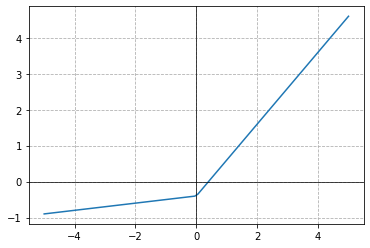

In [76]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [77]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [78]:
def get_model(act=nn.ReLU, nfs=None): # nfs = nb of filters
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

We don't have normal relu anymore, we have to take into account the leakiness for the initialization (the substraction has no impact for initialization):

In [79]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [80]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [81]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.774,0.625,0,train
0.847,0.419,0,eval
0.868,0.361,1,train
0.860,0.375,1,eval
0.880,0.325,2,train
0.866,0.365,2,eval


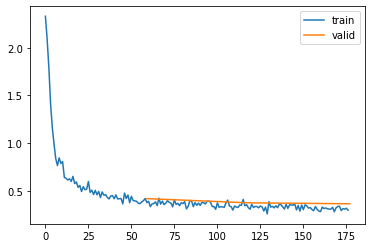

In [82]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

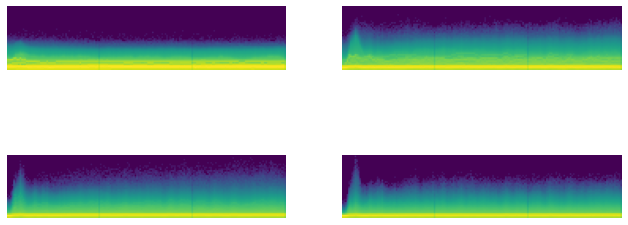

In [83]:
astats.color_dim()

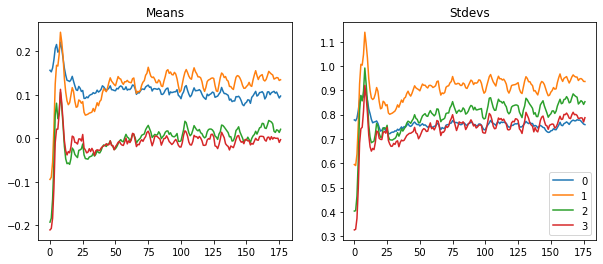

In [84]:
astats.plot_stats()

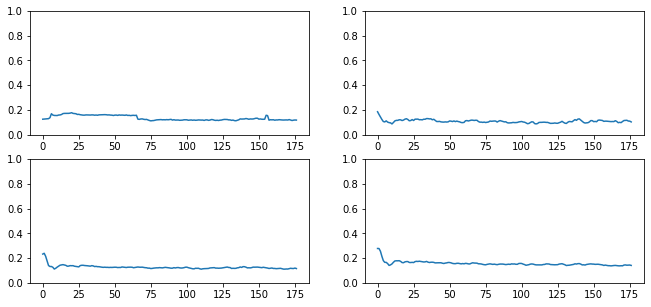

In [85]:
astats.dead_chart()

The percentage of dead units is very small!

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [86]:
#| export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [87]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [88]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [89]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.649,0,train
0.835,0.455,0,eval
0.862,0.379,1,train
0.850,0.404,1,eval
0.876,0.337,2,train
0.859,0.377,2,eval


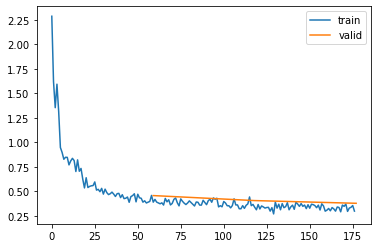

In [90]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

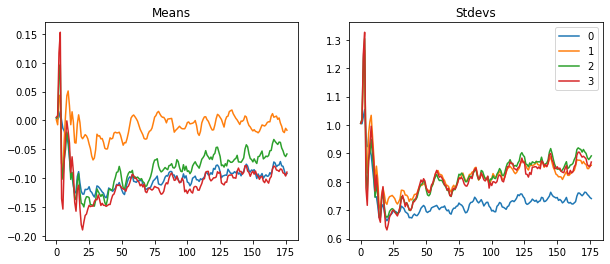

In [91]:
astats.plot_stats()

So here we didn't do any initialization other than LSUV!

Homework: try to write a callback for LSUV (one issue to think about is that if we called fit several time it would initialize the weight each time)

## Batch Normalization

Up to now, we have initialized our weights before training, now we're going to normalize our layer inputs ***during*** training!

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

In [92]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5): # dummy because LayerNorm doesn't care about the number of inputs nf, but BatchNorm does care as we'll see later
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        # so mult and add are trainable parameters 

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # NCHW so here we're taking the mean for each input in the batch
        v = x.var ((1,2,3), keepdim=True) # same for the variance   
        x = (x-m) / ((v+self.eps).sqrt()) # we divide by the standard deviation, and we use eps in case v is very small, to avoid ending up with a giant x 
        return x*self.mult + self.add #  maybe it's better not to normalize, maybe it's better to have something other than mean of 0 and std of 1, that's why we use mult and add

It becomes easier for the network to focus on those two parameters to create any kind of distribution of outputs (for each layer) it wants.

Note that mult and add a single numbers and not vectors of numbers of length *batch size*, whereas m and v are vectors of length *batch size*

Now we need to modify `conv` and `get_model` again to be able to add the option of normalizing:

In [93]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [94]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.781,0.606,0,train
0.845,0.422,0,eval
0.864,0.370,1,train
0.860,0.376,1,eval
0.882,0.321,2,train
0.868,0.358,2,eval


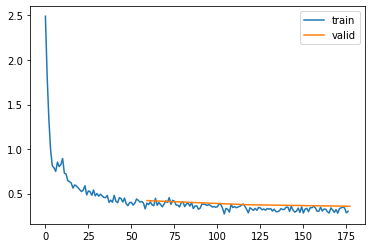

In [95]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

Lerp is an exponentially weighted moving average. This will allow us to have something much smoother, as a single weired mini batch will not be able to screw things around.

In [96]:
torch.lerp(tensor(5.), tensor(15.), tensor(0.5))

tensor(10.)

In [97]:
torch.lerp(tensor(5.), tensor(15.), tensor(0.8))

tensor(13.)

In [98]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) # register_buffer means that vars and means will be saved as part of the model 
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True) # now we have one mean per channel
        v = x.var ((0,2,3), keepdim=True) # same for the variance 
        self.means.lerp_(m, self.mom) # equivalent to:  self.means = (1 - self.mom) * self.means + self.mom * m
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars # during inference, we just use the saved means and variances 
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds # now we are multiplying by a vector of mults and adding a vector of adds, 
                                        # that's why we to pass the number of filters to be able to initialize theses
                                        #  parameters correctly in __init__

accuracy,loss,epoch,train
0.799,0.551,0,train
0.836,0.517,0,eval
0.875,0.341,1,train
0.867,0.370,1,eval
0.886,0.307,2,train
0.869,0.364,2,eval


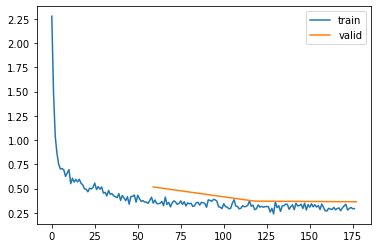

In [99]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90%...

Instead of batch size of 1024 (which we used for speed purposes), let's use 256. It's going to train slower but will be more accurate because the network will see more batches and therefore it will have more opportunities to update. Yann Lecun: the ideal batch size is 1 but that's too slow.

In [100]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.837,0.450,0,train
0.868,0.363,0,eval
0.883,0.317,1,train
0.859,0.380,1,eval
0.897,0.279,2,train
0.890,0.304,2,eval


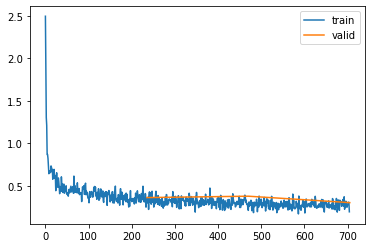

In [101]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Let's keep the existing model, decrease the learning rate, and train for a little bit longer:

accuracy,loss,epoch,train
0.918,0.222,0,train
0.895,0.285,0,eval
0.922,0.210,1,train
0.900,0.277,1,eval


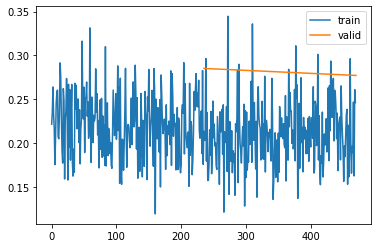

In [102]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

<div class="alert alert-block alert-warning">
<b>Alert:</b> BatchNorm is not a silver bullet and is creating all kind of complexities, so in the last years people have been trying to remove it or at leat decrease its effects, therefore it is increasingly important to know how to properly initialize our weights with the techniques we've seen earlier in this notebook.
</div>

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()